<a href="https://colab.research.google.com/github/Amanda-Sibanda/agriBORA-Commodity-Price-Forecasting/blob/main/Data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

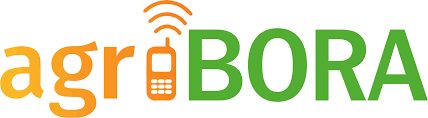

#****agriBORA Commodity Price Forecasting****

Smallholder farmers in Kenya face significant maize price volatility and high post-harvest losses. agriBORA helps farmers store their produce safely and access credit, but effective decision-making still depends on knowing when to sell for the best price.

In this project, we use historical weekly maize prices to build a machine learning model that forecasts average prices for Kiambu, Kirinyaga, Mombasa, Nairobi, and Uasin-Gishu.
The model must predict two weeks ahead at each step, covering the period from November 17, 2025 to January 10, 2026.

Accurate forecasts will support better market timing, improve farmer earnings, and strengthen agriBORA’s market intelligence tools.

#*****Data Preparation*****

**Data**

*   First dataset is from ***Kamis***,  the Kenya Agricultural Market Information System. It is a state portal by Kenya's Ministry of Agriculture that provides real-time market data on commodity prices and conditions to farmers and traders.
 It consists of historical prices for three types of maize (white,   yellow
and mixed-traditional)  from 2021 - 2025/07.
The dataframe has 21888 rows and 14 columns.

*   Second dataset is from ***AgriBBORA***, an agri fintech company that protects grain, unlocks instant financing and links farmers and agriHUBS to reliable markets across East Africa. It consists of transaction data between businesses showing the weekly white maize prices from 2023/10 - 2025/10.
The dataframe has 808 rows and 6 columns.



In [ ]:
## Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/agribora-commodity-price-forecasting-challenge20251124-1142-1vfhirx/"

In [ ]:
## Load the data
kamis_df = pd.read_csv(path +'kamis_maize_prices.csv')
agri_df = pd.read_csv(path +'agribora_maize_prices.csv')
kamis_raw_df = pd.read_csv(path + "kamis_maize_prices_raw.csv")

In [ ]:
kamis_df.head(3)

,Commodity_Classification,Commodity,Classification,County,Market,Date,Year,Month,Year_Month,WeekofYear,Year_Week,SupplyVolume,Retail,Wholesale,Unit
0,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Kabarnet_Market,2021-05-24,2021,5,2021-05,21,2021-21,2700.0,30.0,25.0,Kg
1,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Marigat_Market,2021-05-24,2021,5,2021-05,21,2021-21,14000.0,30.0,27.0,Kg
2,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Marigat_Market,2021-05-24,2021,5,2021-05,21,2021-21,14000.0,30.0,27.0,Kg


In [ ]:
agri_df.head(3)

,County,Date,WholeSale,Commodity_Classification,Year_Week,WeekofYear
0,Nairobi,2023-10-03,50.00,Dry_White_Maize,2023-40,40
1,Kirinyaga,2023-10-03,48.89,Dry_White_Maize,2023-40,40
2,Kisumu,2023-10-03,44.44,Dry_White_Maize,2023-40,40


**Data Cleaning**

In [ ]:
 # Number of missing rows per column in kamis_df
kamis_missing_per_column = kamis_df.isnull().sum()
print("Missing values per column in kamis_df:")
print(kamis_missing_per_column)

# Number of missing rows per column in agri_df
agri_missing_per_column = agri_df.isnull().sum()
print("\nMissing values per column in agri_df:")
print(agri_missing_per_column)

Missing values per column in kamis_df:
Commodity_Classification       0
Commodity                      0
Classification                 0
County                         0
Market                         0
Date                           0
Year                           0
Month                          0
Year_Month                     0
WeekofYear                     0
Year_Week                      0
SupplyVolume                4506
Retail                       872
Wholesale                   1685
Unit                           0
dtype: int64

Missing values per column in agri_df:
County                      3
Date                        0
WholeSale                   2
Commodity_Classification    0
Year_Week                   0
WeekofYear                  0
dtype: int64


In [ ]:
# Impute columns with missing data with group medians.
# Group by Year-Week, Commodity-Classification, County and Market.
# have hierechial grouping for groups with null averages for whatever reason

group_cols_kamis = [
    'Year_Week',
    'Commodity_Classification',
    'County',
    'Market'
]

impute_cols = kamis_df.select_dtypes(include='number').columns

# Level 1
kamis_df[impute_cols] = (
    kamis_df
    .groupby(group_cols_kamis)[impute_cols]
    .transform(lambda x: x.fillna(x.median()))
)

# Level 2
kamis_df[impute_cols] = (
    kamis_df
    .groupby(['Year_Week', 'Commodity_Classification', 'County'])[impute_cols]
    .transform(lambda x: x.fillna(x.median()))
)

# Level 3
kamis_df[impute_cols] = (
    kamis_df
    .groupby(['Year_Week', 'Commodity_Classification'])[impute_cols]
    .transform(lambda x: x.fillna(x.median()))
)

# Level 4
kamis_df[impute_cols] = (
    kamis_df
    .groupby(['Month', 'Commodity_Classification'])[impute_cols]
    .transform(lambda x: x.fillna(x.median()))
)

kamis_df[impute_cols] = kamis_df[impute_cols].fillna(
    kamis_df[impute_cols].median()
)


In [ ]:
# Confirm successfull inputation in Kamis data

kamis_df.isnull().sum()

,0
Commodity_Classification,0
Commodity,0
Classification,0
County,0
Market,0
Date,0
Year,0
Month,0
Year_Month,0
WeekofYear,0


In [ ]:
# Drop rows with missing County in agri_df
agri_df = agri_df.dropna(subset=['County'])

# Impute missing WholeSale rows with group average.
# Group by County and Year_Week
agri_df['WholeSale'] = (
    agri_df
    .groupby(['Year_Week', 'County'])['WholeSale']
    .transform(lambda x: x.fillna(x.median()))
)


In [ ]:
agri_df.isnull().sum()

,0
County,0
Date,0
WholeSale,0
Commodity_Classification,0
Year_Week,0
WeekofYear,0


**Trimming to only relevant data**

Kamis data has 3346 rows and agri data has 749 rows after trim

In [ ]:
# Selecting all entries with White Maize
kamis_df = kamis_df[kamis_df['Commodity_Classification'].str.contains("White_Maize", na=False)].copy()

agri_df = agri_df[agri_df['Commodity_Classification'].str.contains("White_Maize", na=False)].copy()

In [ ]:
## The unique counties in the agriBORA dataset
agri_df.County.unique()

array(['Nairobi', 'Kirinyaga', 'Kisumu', 'Uasin-Gishu', 'Kiambu', 'Embu',
       'Nyeri', 'Mombasa', 'Bungoma', 'Meru', 'Busia', 'Kakamega',
       'Nakuru', 'Machakos', 'Kajiado', 'Trans-Nzoia'], dtype=object)

In [ ]:
## The unique counties in the KAMIS dataset
kamis_df.County.unique()

array(['Baringo', 'Bungoma', 'Busia', 'Elgeyo-Marakwet', 'Garissa',
       'Homa-Bay', 'Isiolo', 'Kajiado', 'Kakamega', 'Kericho', 'Kiambu',
       'Kilifi', 'Kirinyaga', 'Kisii', 'Kisumu', 'Kitui', 'Laikipia',
       'Makueni', 'Mandera', 'Marsabit', 'Meru', 'Migori', 'Mombasa',
       'Nairobi', 'Nakuru', 'Nandi', 'Nyamira', 'Nyeri', 'Siaya',
       'Taita-Taveta', 'Tharaka-Nithi', 'Turkana', 'Uasin-Gishu',
       'Vihiga', 'West-Pokot', 'Bomet', 'Machakos', 'Muranga', 'Embu',
       'Trans-Nzoia', 'Samburu', 'Narok', 'Nyandarua', 'Tana-River',
       'Kwale', 'Lamu'], dtype=object)

In [ ]:
## The counties of interest
target_counties = {"Kiambu","Kirinyaga","Mombasa","Nairobi","Uasin-Gishu"}

In [ ]:
## Restricting datasets to target counties
kamis_df = kamis_df[kamis_df['County'].isin(target_counties)]
agri_df = agri_df[agri_df['County'].isin(target_counties)]

In [ ]:
kamis_df.shape

(3346, 15)

In [ ]:
agri_df.shape

(749, 6)

**Overlap data**

  Overlap data between Kamis and agriBora datasets has 1058 rows and 14 columns

In [ ]:
kdf = kamis_df.rename(columns={'Wholesale': 'Kamis_Wholesale'})

In [ ]:
adf = agri_df.rename(columns ={'WholeSale' : 'Agri_WholeSale'})

In [ ]:
# Is there an overlap between kamis & agribora data ?
overlap = (
    adf.merge(kdf, on=['County', 'Year_Week'], how='inner')
    .sort_values(['County', 'Year_Week'])
)

In [ ]:
overlap.shape

(1058, 19)

In [ ]:
## Drop repeating/redudant columns
cols_to_drop = [
    'Date_y',
    'Commodity_Classification_y',
    'WeekofYear_y',
    'Commodity',
    'Classification'
]

overlap = overlap.drop(columns=cols_to_drop)


In [ ]:
## Rename columns to consistent formatting

overlap = overlap.rename(columns={
    'County': 'County',
    'Date_x': 'Date',
    'Agri_WholeSale': 'Agri_WholeSale',
    'Commodity_Classification_x': 'Commodity_Classification',
    'Year_Week': 'Year_Week',
    'WeekofYear_x': 'Week_of_Year',
    'Market': 'Market',
    'Year': 'Year',
    'Month': 'Month',
    'Year_Month': 'Year_Month',
    'SupplyVolume': 'Supply_Volume',
    'Retail': 'Retail_Price',
    'Kamis_Wholesale': 'Kamis_WholeSale',
    'Unit': 'Unit'
})


In [ ]:
overlap.head(2)

,County,Date,Agri_WholeSale,Commodity_Classification,Year_Week,Week_of_Year,Market,Year,Month,Year_Month,Supply_Volume,Retail_Price,Kamis_WholeSale,Unit
10,Kirinyaga,2023-10-03,48.89,Dry_White_Maize,2023-40,40,Ngurubani_Market,2023,10,2023-10,6000.0,60.0,44.44,Kg
11,Kirinyaga,2023-10-03,48.89,Dry_White_Maize,2023-40,40,Makutano_Kirinyaga_Market,2023,10,2023-10,4500.0,60.0,40.00,Kg


In [ ]:
overlap.shape

(1058, 14)

In [ ]:
kamis_df.head()

,Commodity_Classification,Commodity,Classification,County,Market,Date,Year,Month,Year_Month,WeekofYear,Year_Week,SupplyVolume,Retail,Wholesale,Unit
332,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,9000.0,40.0,30.00,Kg
333,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Limuru_Rongai_Market,2021-05-24,2021,5,2021-05,21,2021-21,7200.0,40.0,28.89,Kg
334,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Limuru_Rongai_Market,2021-05-24,2021,5,2021-05,21,2021-21,45000.0,35.0,30.00,Kg
335,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,18000.0,45.0,20.00,Kg
338,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,4000.0,50.0,32.22,Kg


In [ ]:
agri_df

,County,Date,WholeSale,Commodity_Classification,Year_Week,WeekofYear
0,Nairobi,2023-10-03,50.00,Dry_White_Maize,2023-40,40
1,Kirinyaga,2023-10-03,48.89,Dry_White_Maize,2023-40,40
3,Uasin-Gishu,2023-10-03,46.67,Dry_White_Maize,2023-40,40
4,Uasin-Gishu,2023-10-03,46.67,Dry_White_Maize,2023-40,40
5,Nairobi,2023-10-04,50.00,Dry_White_Maize,2023-40,40
...,...,...,...,...,...,...
803,Uasin-Gishu,2025-10-06,36.67,Dry_White_Maize,2025-40,41
804,Uasin-Gishu,2025-10-06,38.89,Dry_White_Maize,2025-40,41
805,Uasin-Gishu,2025-10-06,38.89,Dry_White_Maize,2025-40,41
806,Uasin-Gishu,2025-09-24,38.89,Dry_White_Maize,2025-38,39


**Kamis and AgriBora merge**

In [ ]:
# Rename columns to distinguish KAMIS and Agribora
kamis = kamis_df.rename(columns={'Wholesale': 'Wholesale_kamis', 'Commodity_Classification': 'Commodity_Classification_kamis'})
agri = agri_df.rename(columns={'WholeSale': 'Wholesale_agribora', 'Commodity_Classification': 'Commodity_Classification_agribora'})

# Merge KAMIS and Agribora on County + Date + Commodity_Classification
# Full outer join keeps all records from both datasets
data = kamis.merge(
    agri[['County','Date','Commodity_Classification_agribora','Wholesale_agribora']],
    left_on=['County','Date','Commodity_Classification_kamis'],
    right_on=['County','Date','Commodity_Classification_agribora'],
    how='outer',  # full outer join
    suffixes=('_kamis','_agribora')
)



In [ ]:
data.head(2)

,Commodity_Classification_kamis,Commodity,Classification,County,Market,Date,Year,Month,Year_Month,WeekofYear,Year_Week,SupplyVolume,Retail,Wholesale_kamis,Unit,Commodity_Classification_agribora,Wholesale_agribora
0,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021.0,5.0,2021-05,21.0,2021-21,9000.0,40.0,30.00,Kg,NaN,NaN
1,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Limuru_Rongai_Market,2021-05-24,2021.0,5.0,2021-05,21.0,2021-21,7200.0,40.0,28.89,Kg,NaN,NaN


In [ ]:
# Ensure Date is datetime
data['Date'] = pd.to_datetime(data['Date'])

# Year
data['Year'] = data['Date'].dt.year

# Month
data['Month'] = data['Date'].dt.month

# Year_Month (use YYYY-MM format)
data['Year_Month'] = data['Date'].dt.to_period('M').astype(str)

# Week of year
data['WeekofYear'] = data['Date'].dt.isocalendar().week

# Year_Week (YYYY-WW format)
data['Year_Week'] = data['Date'].dt.to_period('W').apply(lambda r: f"{r.start_time.year}-{r.start_time.isocalendar()[1]}")


In [ ]:
# Number of missing rows per column in merged data
merged_missing_per_column = data.isnull().sum()
print("\nMissing values per column in merged data:")
print(merged_missing_per_column)


Missing values per column in merged data:
Commodity_Classification_kamis        647
Commodity                             647
Classification                        647
County                                  0
Market                                647
Date                                    0
Year                                    0
Month                                   0
Year_Month                              0
WeekofYear                              0
Year_Week                               0
SupplyVolume                          647
Retail                                647
Wholesale_kamis                       647
Unit                                  647
Commodity_Classification_agribora    3192
Wholesale_agribora                   3192
dtype: int64


In [ ]:
# Impute missing data with medians

# level 1
data['Retail'] = data.groupby(['County', 'Date'])['Retail'].transform(lambda x: x.fillna(x.median()))
data['SupplyVolume'] = data.groupby(['County', 'Date'])['SupplyVolume'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_kamis'] = data.groupby(['County', 'Date'])['Wholesale_kamis'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_agribora'] = data.groupby(['County', 'Date'])['Wholesale_agribora'].transform(lambda x: x.fillna(x.median()))

# level 2
data['Retail'] = data.groupby(['County', 'Year_Week'])['Retail'].transform(lambda x: x.fillna(x.median()))
data['SupplyVolume'] = data.groupby(['County', 'Year_Week'])['SupplyVolume'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_kamis'] = data.groupby(['County', 'Year_Week'])['Wholesale_kamis'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_agribora'] = data.groupby(['County', 'Year_Week'])['Wholesale_agribora'].transform(lambda x: x.fillna(x.median()))

# level 3
data['Retail'] = data.groupby(['County', 'Year_Month'])['Retail'].transform(lambda x: x.fillna(x.median()))
data['SupplyVolume'] = data.groupby(['County', 'Year_Month'])['SupplyVolume'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_kamis'] = data.groupby(['County', 'Year_Month'])['Wholesale_kamis'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_agribora'] = data.groupby(['County', 'Year_Month'])['Wholesale_agribora'].transform(lambda x: x.fillna(x.median()))

# level 4
data['Retail'] = data.groupby(['County', 'WeekofYear'])['Retail'].transform(lambda x: x.fillna(x.median()))
data['SupplyVolume'] = data.groupby(['County', 'WeekofYear'])['SupplyVolume'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_kamis'] = data.groupby(['County', 'WeekofYear'])['Wholesale_kamis'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_agribora'] = data.groupby(['County', 'WeekofYear'])['Wholesale_agribora'].transform(lambda x: x.fillna(x.median()))

# level 5
data['Retail'] = data.groupby(['County', 'Month'])['Retail'].transform(lambda x: x.fillna(x.median()))
data['SupplyVolume'] = data.groupby(['County', 'Month'])['SupplyVolume'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_kamis'] = data.groupby(['County', 'Month'])['Wholesale_kamis'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_agribora'] = data.groupby(['County', 'Month'])['Wholesale_agribora'].transform(lambda x: x.fillna(x.median()))

# level 6
data['Retail'] = data.groupby(['County', 'Year'])['Retail'].transform(lambda x: x.fillna(x.median()))
data['SupplyVolume'] = data.groupby(['County', 'Year'])['SupplyVolume'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_kamis'] = data.groupby(['County', 'Year'])['Wholesale_kamis'].transform(lambda x: x.fillna(x.median()))
data['Wholesale_agribora'] = data.groupby(['County', 'Year'])['Wholesale_agribora'].transform(lambda x: x.fillna(x.median()))



In [ ]:
data.drop(columns=['Unit'], inplace=True) # Unit column does not have any predictive power therefore it is useless to keep for modelling

KeyError: "['Unit'] not found in axis"

In [ ]:
data.head(2)

,Commodity_Classification_kamis,Commodity,Classification,County,Market,Date,Year,Month,Year_Month,WeekofYear,Year_Week,SupplyVolume,Retail,Wholesale_kamis,Commodity_Classification_agribora,Wholesale_agribora
0,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,9000.0,40.0,30.00,Dry_White_Maize,42.22
1,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Limuru_Rongai_Market,2021-05-24,2021,5,2021-05,21,2021-21,7200.0,40.0,28.89,Dry_White_Maize,42.22


In [ ]:
# Impute categorical columns
data['Commodity_Classification_kamis'] = data['Commodity_Classification_kamis'].fillna('Dry_White_Maize')
data['Commodity'] = data['Commodity'].fillna('Dry_Maize')
data['Classification'] = data['Classification'].fillna('White_Maize')
data['Commodity_Classification_agribora'] = data['Commodity_Classification_agribora'].fillna('Dry_White_Maize')


In [ ]:
# Impute Agribora missing markets as "Business"
data['Market'] = data['Market'].fillna('Business')

In [ ]:
# Confirm successful imputation
# Number of missing rows per column in merged data
merged_missing_per_column = data.isnull().sum()
print("\nMissing values per column in merged data:")
print(merged_missing_per_column)


Missing values per column in merged data:
Commodity_Classification_kamis       0
Commodity                            0
Classification                       0
County                               0
Market                               0
Date                                 0
Year                                 0
Month                                0
Year_Month                           0
WeekofYear                           0
Year_Week                            0
SupplyVolume                         0
Retail                               0
Wholesale_kamis                      0
Commodity_Classification_agribora    0
Wholesale_agribora                   0
dtype: int64


**Analysis to ensure data accuracy after imputation**

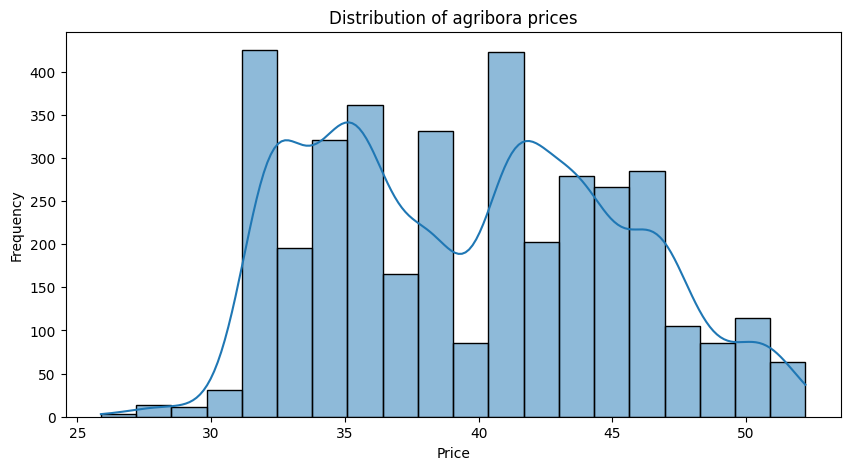

In [292]:
plt.figure(figsize=(10,5))
sns.histplot(data['Wholesale_agribora'], bins=20, kde=True)
plt.title('Distribution of agribora prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

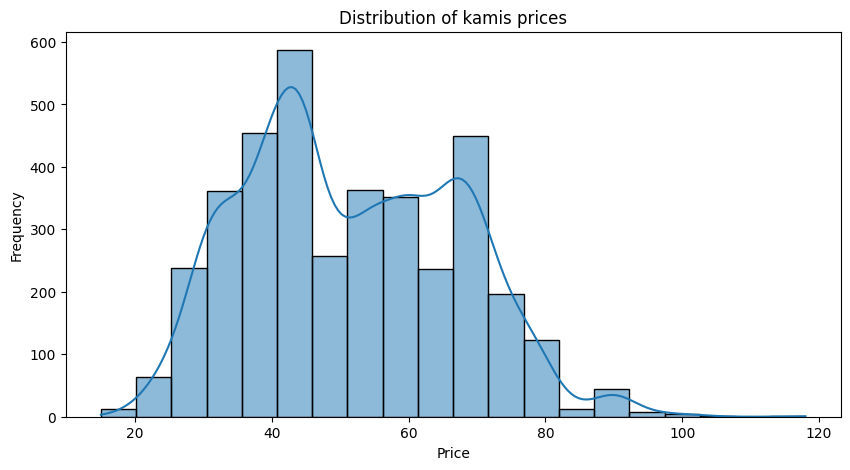

In [294]:
plt.figure(figsize=(10,5))
sns.histplot(data['Wholesale_kamis'], bins=20, kde=True)
plt.title('Distribution of kamis prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

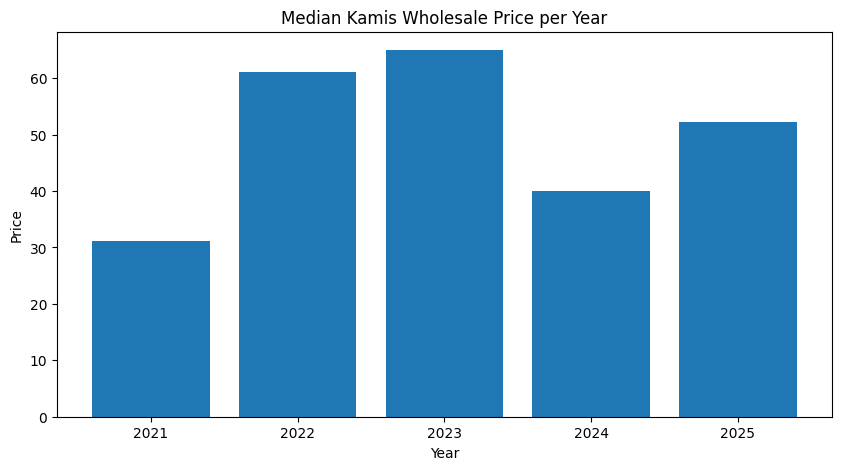

In [296]:
# Kamis
kamis_year_avg = data.groupby('Year')['Wholesale_kamis'].median()
plt.figure(figsize=(10,5))
plt.bar(kamis_year_avg.index, kamis_year_avg.values)
plt.title('Median Kamis Wholesale Price per Year')
plt.ylabel('Price')
plt.xlabel('Year')
plt.show()


**Save data**

In [ ]:
# Generate a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

# Save kamis_df
kamis_df.to_csv(f'kamis_cleaned_{timestamp}.csv', index=False)

# Save agri_df
agri_df.to_csv(f'agri_cleaned_{timestamp}.csv', index=False)

# Save overlap df
overlap.to_csv(f'overlap_{timestamp}.csv', index=False)

# Save merged df
data.to_csv(f'merged_cleaned_{timestamp}.csv, index = Fals')